In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import csv
import copy
import pdb

In [2]:
matplotlib.rcParams['figure.figsize'] = [26,8]

#### Model

In [37]:
class RBF(nn.Module):
    def __init__(self):
        '''Implements RBF nonlinearity'''
        super(RBF, self).__init__()
        self.b = 1 # nn.Parameter(torch.ones(1))
        self.c = 0 # nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return torch.exp(- self.b * ((x - self.c)*(x - self.c)))
        
class FFNet(nn.Module):
    def __init__(self, layers):
        '''Layers includes first and last layers'''
        super(FFNet, self).__init__()
        
        # Stack neural network layers
        stack = []
        for i in range(len(layers)-1):
            lin = nn.Linear(layers[i], layers[i+1])
            non = RBF()
            stack = stack + [lin, non] if i != len(layers) - 2 else stack + [lin]
        self.net = nn.Sequential(*stack)
            
    def gaussian_sample_init_(self, m=0, s=1):
        for p in self.parameters():
            p.data.normal_(mean=m, std=s)
        return self
    
    def z_init_(self, size):
        '''Initialize z, which will live with the model for training'''
        self.z = nn.Parameter(torch.randn(size))
        return self
            
    def forward(self, x, train=True, use_z=True):
        '''Sample z and return output of net'''
        if use_z:
            z = self.z if train else torch.randn(x.shape)
            assert x.shape == z.shape, 'x and z have different shapes'
            x = torch.cat((x, z), dim=1)
        return self.net(x)

#### Sampling from the Posterior

In [84]:
# GPU
device = torch.device('cpu')

# Data
X, Y = [], []
with open('data/data.csv','r') as f:
    reader = csv.reader(f)
    for l in reader: X.append(float(l[0]));Y.append(float(l[1]));
X = torch.FloatTensor(np.array(X)).reshape(-1,1) # = torch.tensor([-2.0,-1.8,-1.0,1,1.8,2]).reshape(-1,1).to(device)
Y = torch.FloatTensor(np.array(Y)).reshape(-1,1) # = - X*X*X*X + 3*X*X + 1
X_range = torch.arange(-5,5,0.05).reshape(-1,1).to(device)

# Hyperparameters
use_z = True
layers = [2,5,1] if use_z else [1,5,1]
lr = 2.00e-2
L = 30
burnin_samples = int(1e4)
collect_samples = int(1e3)

In [92]:
def to_numpy(t):
    '''Tensor to numpy'''
    return t.detach().to('cpu').numpy()

def negative_log_probability(model, x=X, y=Y, noise_sigma=0.1, prior_sigma=1.0, z_sigma=1.0):
    '''Negative log probability is squared error'''
        
    # Forward model
    y_hat = model(x)
    
    # Compute likelihood
    log_p = sum(torch.sum(p*p) for p in model.parameters()) / (2 * prior_sigma**2)
    log_l = torch.sum((y_hat - y)*(y_hat - y)) / (2 * noise_sigma**2)
    log_z = torch.sum(model.z * model.z) / (2 * z_sigma**2)
    return log_p + log_l + log_z

def hamiltonian_monte_carlo(u, eps, steps, curr_q):
    '''Runs a single step of Hamiltonian Monte Carlo.
         Returns the result of the Metropolis step (accepted/old q)'''

    # Sample momentum 
    curr_p = [torch.randn(q_group.shape).to(device) for q_group in curr_q.parameters()]

    # Copy for comparison in Metropolis step
    q = copy.deepcopy(curr_q)
    p = copy.deepcopy(curr_p)

    # Compute gradients with autodiff
    u(q).backward()
    for q_group, p_group in zip(q.parameters(), p):
        p_group.add_( - eps * q_group.grad / 2 )
    q.zero_grad()

    # Run for L steps
    for i in range(steps):
        # Change q
        for q_group, p_group in zip(q.parameters(), p):
            q_group.data.add_( eps * p_group )
        # Change p
        u(q).backward()
        for q_group, p_group in zip(q.parameters(), p):
            p_group.add_( - eps * q_group.grad / (2.0 if i==steps-1 else 1.0) )
        q.zero_grad()
    
    for p_group in p: 
        p_group.mul_(-1)
    
    # Calculate energies
    curr_u = u(curr_q)
    curr_k = sum(torch.sum(p_group*p_group) for p_group in curr_p) / 2
    prop_u = u(q)
    prop_k = sum(torch.sum(p_group*p_group) for p_group in p) / 2
    
    # Accept or reject 
    accept_prob = torch.exp(curr_u - prop_u + curr_k - prop_k).to('cpu')
    if bool(torch.rand(1) < accept_prob):
        return q, 1, curr_u
    else:
        return curr_q, 0, curr_u

# Create potential energy function, model
u = negative_log_probability
curr_q = FFNet(layers)
curr_q = curr_q.gaussian_sample_init_(m=0,s=1.).to(device)

# Create latent variable z
if use_z:
    curr_q.z_init_(X.shape)    
    
# HMC
samples = []
total, accepted = 0, 0
for i in range(burnin_samples + collect_samples):
    
    # HMC
    curr_q, accept, log_l = hamiltonian_monte_carlo(u, lr, L, curr_q)
    
    # Collect test samples
    if i > burnin_samples:
        y_sample = curr_q(X_range, train=False, use_z=use_z)
        samples.append(y_sample)
        
        # Save samples (model)
        torch.save(curr_q, './zwts/curr_q-{}.pth'.format(i))
        torch.save(accept, './zwts/a-{}.pth'.format(i))
        torch.save(log_l,  './zwts/u-{}.pth'.format(i))


    # Statistics
    total += 1
    accepted += accept
    if i % 500 == 100 // 2:
        print('Accepted {:6d} / {:6d} ({:.1f}%)'.format(accepted, total, accepted/total*100))

print('----\nDone')

Accepted     22 /     51 (43.1%)
Accepted    367 /    551 (66.6%)
Accepted    747 /   1051 (71.1%)
Accepted   1043 /   1551 (67.2%)
Accepted   1392 /   2051 (67.9%)
Accepted   1711 /   2551 (67.1%)
Accepted   2061 /   3051 (67.6%)
Accepted   2413 /   3551 (68.0%)
Accepted   2777 /   4051 (68.6%)
Accepted   3133 /   4551 (68.8%)
Accepted   3493 /   5051 (69.2%)
Accepted   3817 /   5551 (68.8%)
Accepted   4172 /   6051 (68.9%)
Accepted   4486 /   6551 (68.5%)
Accepted   4839 /   7051 (68.6%)
Accepted   5193 /   7551 (68.8%)
Accepted   5544 /   8051 (68.9%)
Accepted   5938 /   8551 (69.4%)
Accepted   6282 /   9051 (69.4%)
Accepted   6628 /   9551 (69.4%)


/home/luke/miniconda3/envs/py/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FFNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/luke/miniconda3/envs/py/lib/python3.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RBF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Accepted   6991 /  10051 (69.6%)
Accepted   7310 /  10551 (69.3%)
----
Done


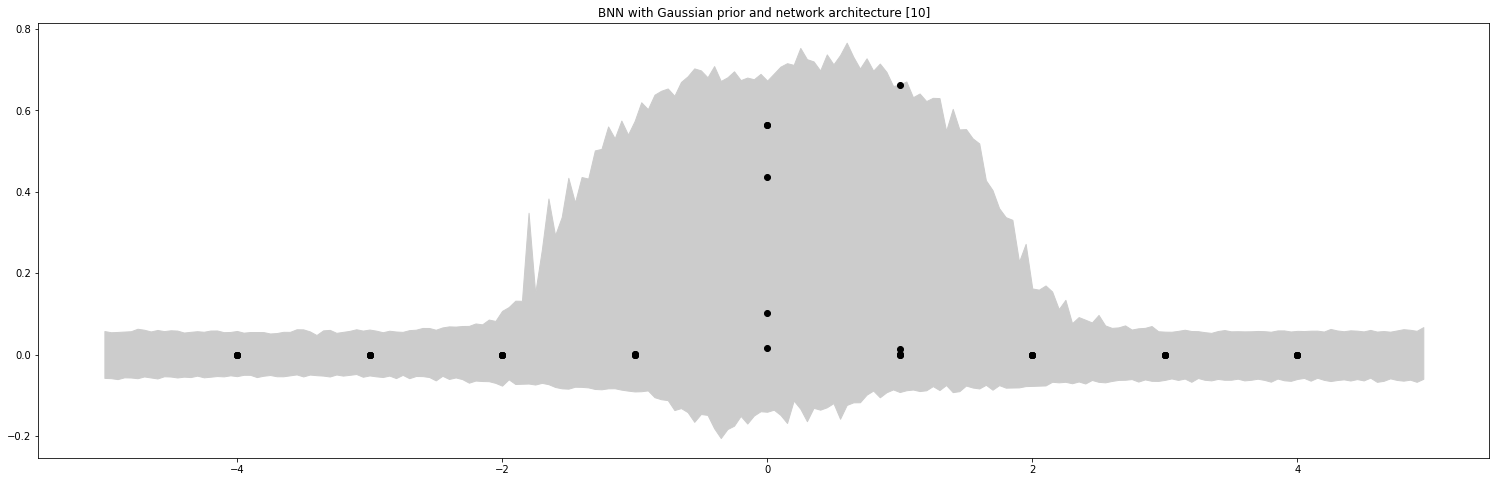

In [93]:
# Prepare samples - torch.save(torch.stack(samples), '1_10_1.pth')
smpls = torch.stack(samples).squeeze().transpose(0,1).detach().cpu().numpy()
upper_95 = np.sort(smpls, axis=1)[:, int(smpls.shape[1] * 0.04)] 
lower_95 = np.sort(smpls, axis=1)[:,-int(smpls.shape[1] * 0.04)]

# Plot
plt.gca().set_title('BNN with Gaussian prior and network architecture [10]')
plt.gca().fill_between(X_range.reshape(-1), upper_95, lower_95, color="#cccccc")
plt.scatter(X, Y, color='black', marker='o')

plt.show()

#### Diagnostics

In [94]:
import pandas as pd

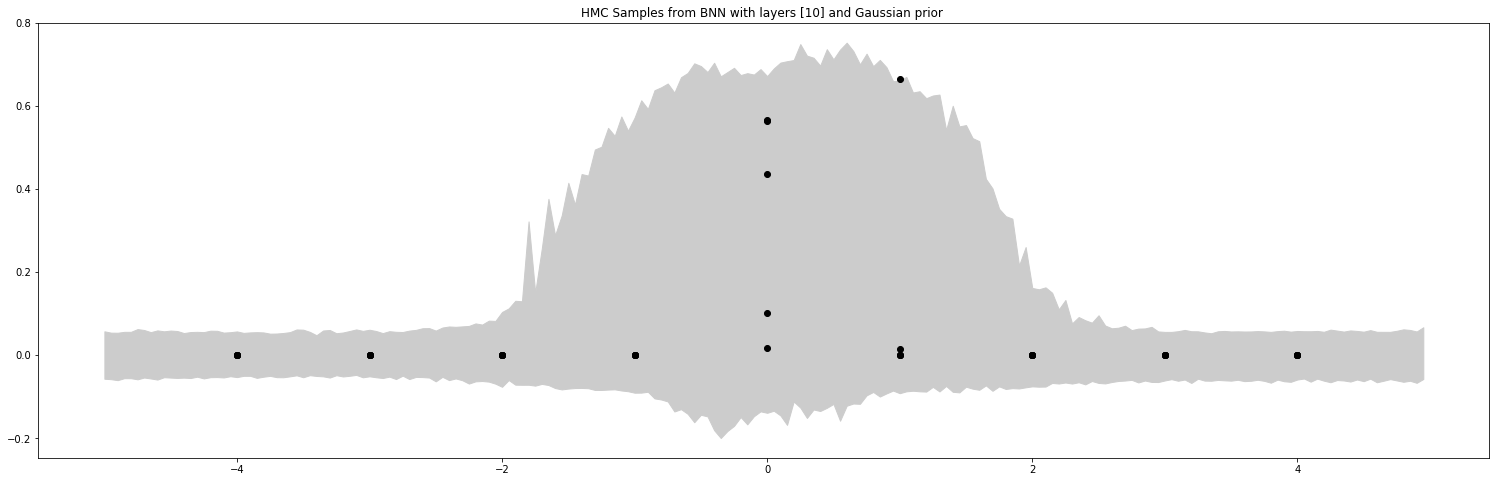

In [97]:
# Confidence interval
bounds = np.sort(to_numpy(torch.cat(samples, dim=1)), axis=1)[:,[40,-40]]
plt.gca().set_title('HMC Samples from BNN with layers [10] and Gaussian prior ')
plt.gca().fill_between(X_range.reshape(-1), bounds[:,1], bounds[:,0], color="#cccccc")
plt.scatter(X, Y, color='black', marker='o')
plt.show()

[]

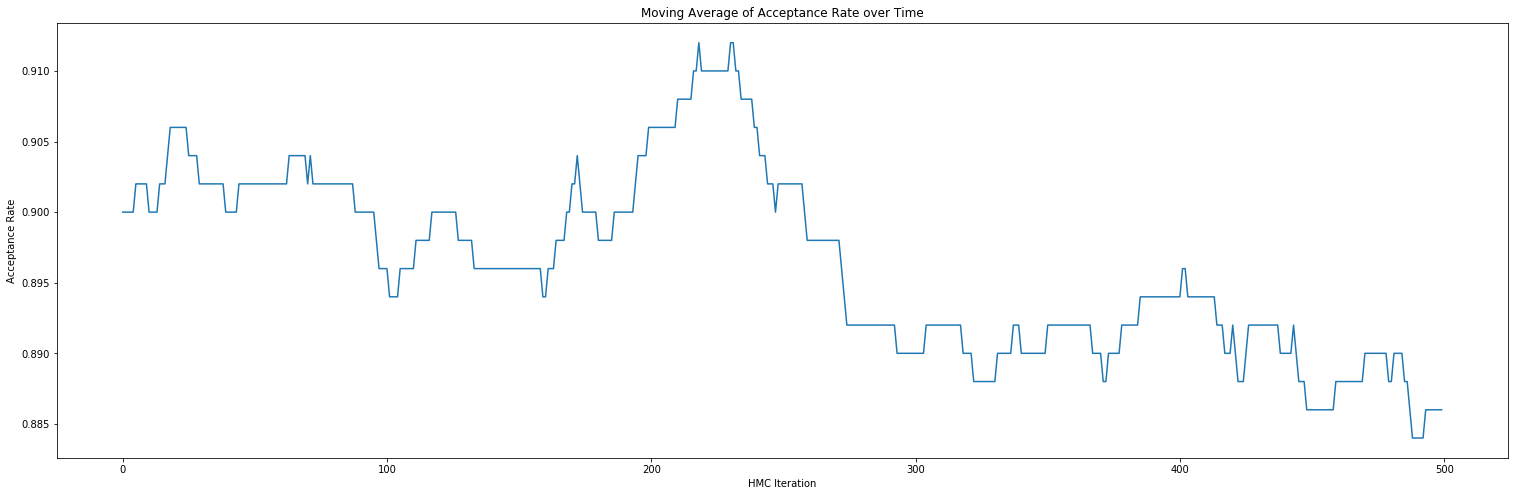

In [98]:
# Acceptance
accepts = []
for i in range(1, collect_samples):
    accept = torch.load('./zwts/a-{}.pth'.format(i))    
    accepts.append(accept)
accepts = np.array(accepts)
accepts = np.convolve(accepts, np.ones((500,))/500, mode='valid') # running mean
plt.plot(accepts) 
plt.title('Moving Average of Acceptance Rate over Time')
plt.ylabel('Acceptance Rate')
plt.xlabel('HMC Iteration')
plt.plot()

[]

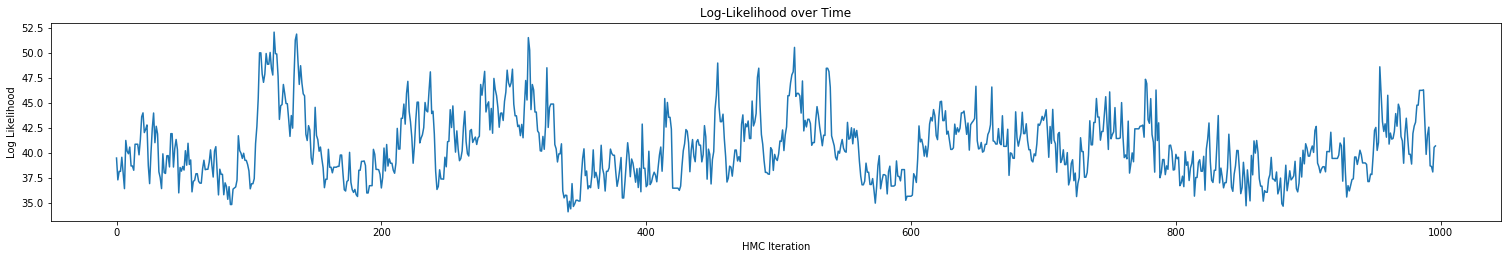

In [99]:
# Acceptance
lls = []
for i in range(1, collect_samples):
    ll = torch.load('./zwts/u-{}.pth'.format(i))    
    lls.append(ll.item())
lls = np.array(lls)
plt.subplot(2,1,1)
plt.plot(lls[2:]) 
# plt.subplot(2,1,2)
# plt.plot(lls[50:]) 
plt.title('Log-Likelihood over Time')
plt.ylabel('Log Likelihood')
plt.xlabel('HMC Iteration')
plt.plot()

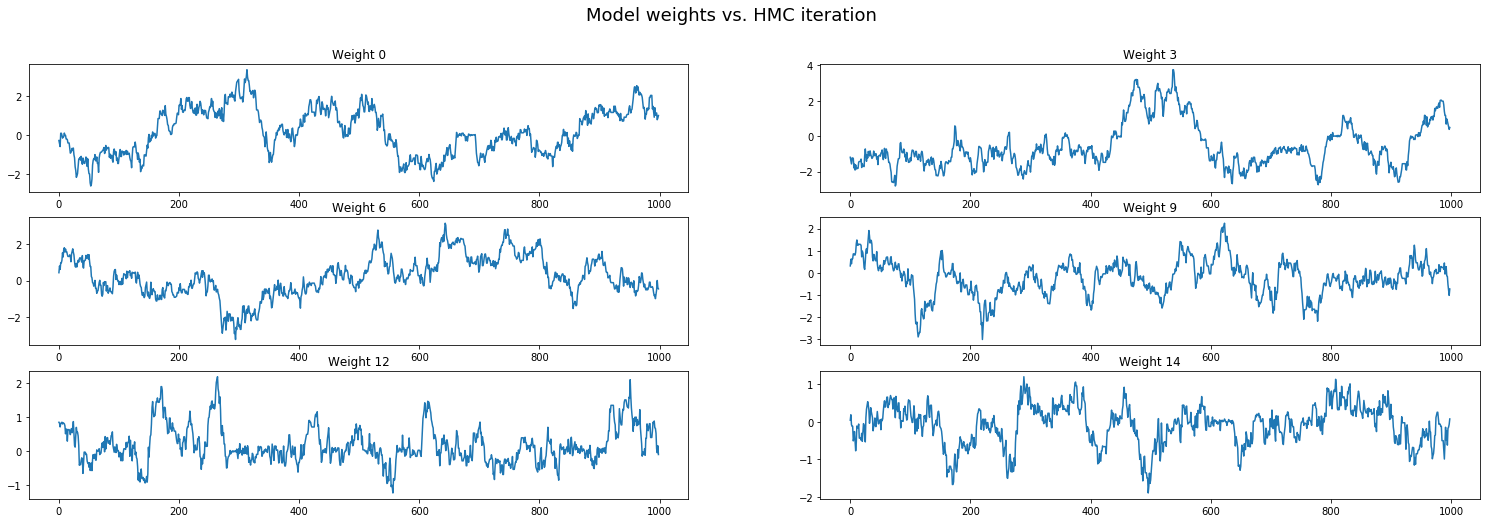

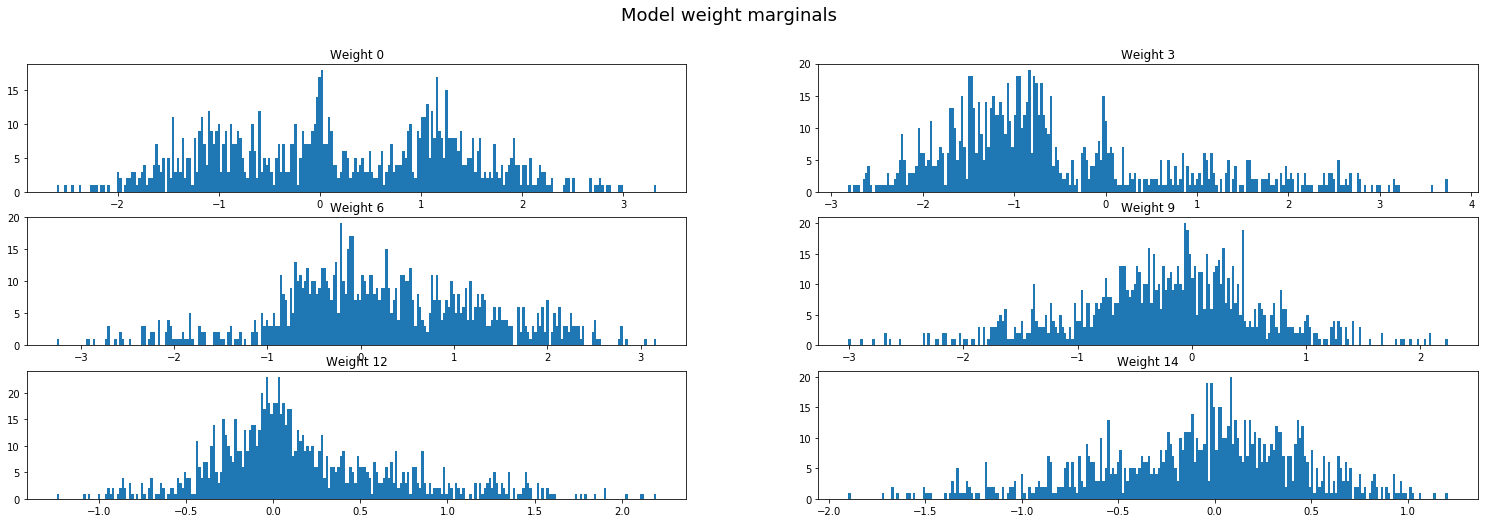

In [101]:
# Load weights
import pandas as pd
wts = []
for i in range(1, collect_samples):
    saved_q = torch.load('./zwts/curr_q-{}.pth'.format(i))
    wts.append([w.item() for ws in saved_q.parameters() for w in ws.reshape(-1)])
wts = np.array(wts)
wts = pd.DataFrame(wts)

# Weights over time
plt.figure()
plt.tight_layout()
plt.suptitle('Model weights vs. HMC iteration', fontsize=18)
for i, w in enumerate([0,3,6,9,12,14]):
    plt.subplot(3,2,i+1)
    plt.title('Weight {}'.format(w))
    plt.plot(wts[w])
plt.show()

# Weight marginals
plt.figure()
plt.tight_layout()
plt.suptitle('Model weight marginals', fontsize=18)
for i, w in enumerate([0,3,6,9,12,14]):
    plt.subplot(3,2,i+1)
    plt.title('Weight {}'.format(w))
    plt.hist(wts[w], bins=250)
plt.show()

/home/luke/miniconda3/envs/py/lib/python3.7/site-packages/matplotlib/pyplot.py:969: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)


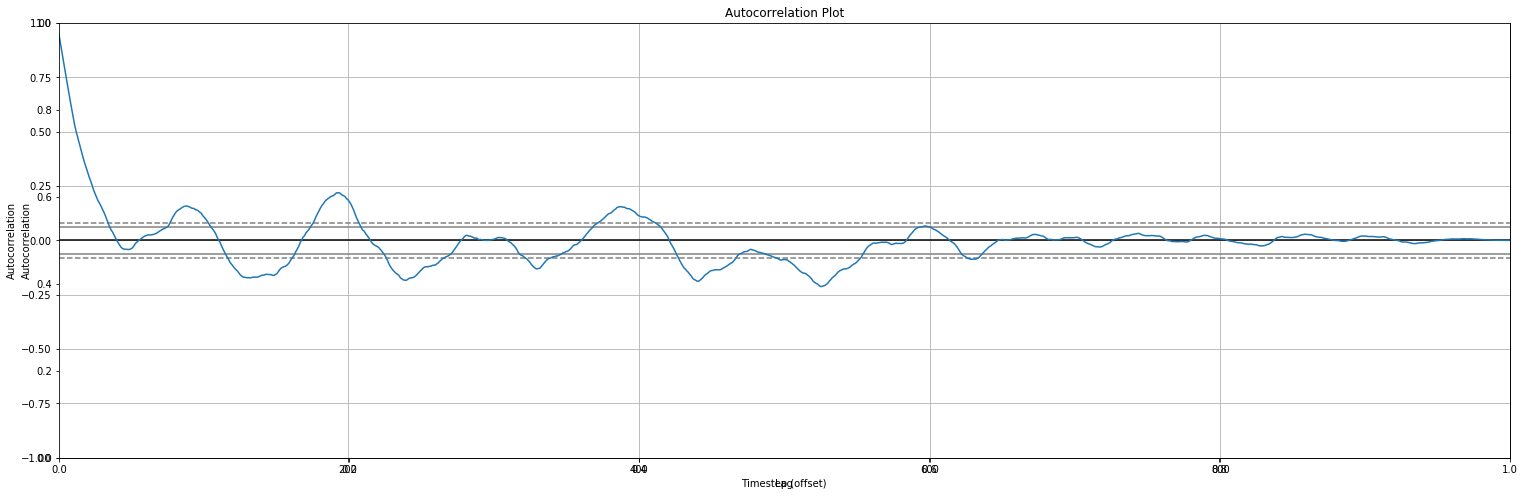

In [102]:
# Autocorrelation plot
plt.title('Autocorrelation Plot')
plt.ylabel('Autocorrelation')
plt.xlabel('Timestep (offset)')
pd.plotting.autocorrelation_plot(wts[5])